# supercombo demo

Supercombo serves as the core of the openpilot system. It is a pre-trained end-to-end
model responsible for decision making regarding the driver assistance tasks(Adaptive
Cruise Control (ACC), Automated Lane Centering (ALC), Forward Collision Warning
(FCW), and Lane Departure Warning (LDW)). While the
model is open-source, the training data and the training process are proprietary. The
[study](https://arxiv.org/abs/2206.08176) explores the possibilities of using, retraining, and evaluating the model on
public benchmarks, providing valuable insights and extensions to the limited official documentation. Besides this study (and obviously the official [github](https://github.com/commaai/openpilot)) you can visualize the supercombo.onnx model in [netron.app](https://netron.app/), to see the architecture more in details. You can find the latest pretrained mode [here](https://github.com/commaai/openpilot/blob/master/selfdrive/modeld/models/supercombo.onnx). <br/>
This notebook will give you an overview using the inputs, and outputs of this model. Interpreting the *main* and recurrent output is not in the scope of this notebook (at least for now).

The first section of this notebook is just some necessary util methods and imports.

In [1]:
import cv2
import json
import numpy as np
import onnxruntime
import pandas as pd
from matplotlib import pyplot as plt
from inputWrapper import InputWrapper
from outputWrapper import OutputWrapper, ModelOutputVisualizer

width = 512
height = 256
dim = (width, height)

def parse_image(frame):
	img = cv2.resize(frame, dim)
	img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV_I420)
	H = (img_yuv.shape[0]*2)//3
	W = img_yuv.shape[1]
	parsed = np.zeros((6, H//2, W//2), dtype=np.uint8)

	parsed[0] = img_yuv[0:H:2, 0::2]
	parsed[1] = img_yuv[1:H:2, 0::2]
	parsed[2] = img_yuv[0:H:2, 1::2]
	parsed[3] = img_yuv[1:H:2, 1::2]
	parsed[4] = img_yuv[H:H+H//4].reshape((-1, H//2,W//2))
	parsed[5] = img_yuv[H+H//4:H+H//2].reshape((-1, H//2,W//2))

	return parsed

def add_text_to_image(image, text, position = (10, 30), color=(0, 0, 255), font=cv2.FONT_HERSHEY_SIMPLEX, scale=1, thickness=2):
    cv2.putText(image, text, position, font, scale, color, thickness, cv2.LINE_AA)

# Camera parameters
camera_height = 1.5
camera_fov = 105

In [2]:
video = cv2.VideoCapture('dashcam.mp4')
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
max_frames = 20 #1 second
frames = []
parsed_images = []
# Loop through the first 5 frames and extract them
for i in range(min(num_frames, max_frames)):
	ret, frame = video.read() 
	if ret:
		# Add the frame to the list
		frames.append(frame)
		parsed_images.append(parse_image(frame))
	else:
		break
		
video.release()

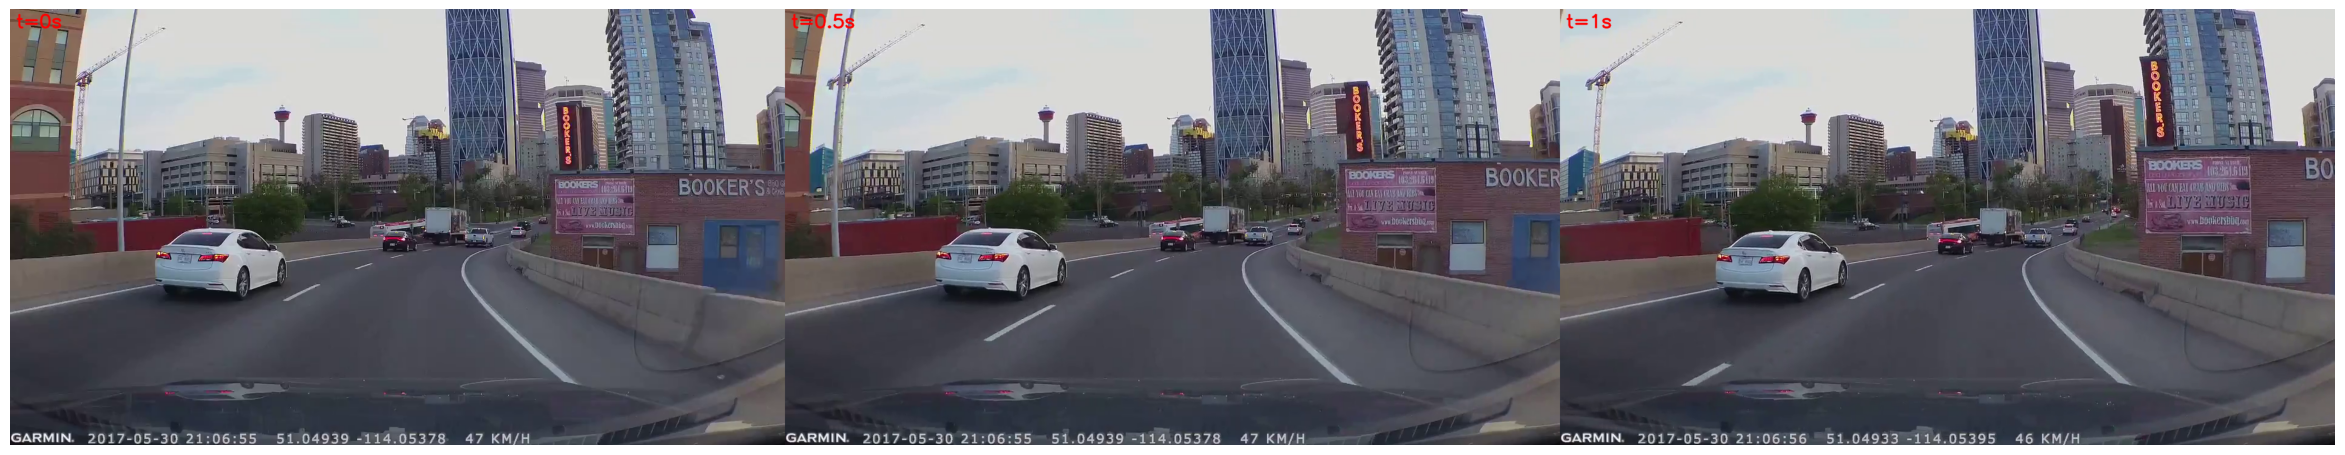

In [3]:
add_text_to_image(frames[0], "t=0s")
add_text_to_image(frames[9], "t=0.5s")
add_text_to_image(frames[19], "t=1s")
row1 = cv2.hconcat([frames[0], frames[9], frames[19]])
plt.figure(figsize=(30, 10))
plt.imshow(cv2.cvtColor(row1, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

I created some input image sequence, to see whether switching frame rate (or speed in real life) impacts the lane detection.

In [4]:
parsed_arr = np.array(parsed_images)
parsed_005 = parsed_arr[[18,19]]# default for proper use case .05sec distance
parsed_050 = parsed_arr[[9,19]]# .5sec distance
parsed_100 = parsed_arr[[0,19]]# 1 second distance

In [5]:
model = "supercombo.onnx"
session = onnxruntime.InferenceSession(model, None)
output_name = session.get_outputs()[0].name
visualizer = ModelOutputVisualizer()

After parsing the image to the correct format according to the [documentation](https://github.com/commaai/openpilot/tree/master/selfdrive/modeld/models#supercombo-input-format-full-size-799906-x-float32), the input image data has to be resized, for feeding it to the model. This is only a structural change in the data. 

In [6]:
parsed_005.resize((1,12,128,256))
parsed_050.resize((1,12,128,256))
parsed_100.resize((1,12,128,256))
data = json.dumps({'data': parsed_005.tolist()})
data = np.array(json.loads(data)['data']).astype('float32')
data_050 = json.dumps({'data': parsed_050.tolist()})
data_050 = np.array(json.loads(data_050)['data']).astype('float32')
data_100 = json.dumps({'data': parsed_100.tolist()})
data_100 = np.array(json.loads(data_100)['data']).astype('float32')

## Input 
Inputwrapper collects the input images, and additionaly completes the missing inputs, by dummy or pre-defined inputs. The model has the following inputs 
 - **Input images**: Two consecutive RGB images (256 * 512 * 3) captured at 20 Hz.
 - **Wide input images**: Relatively new input, in our case I used the same 2 image. todo deepdive parsing code in openpilot to see what is the difference 
 - **Desire**: A one-hot encoded vector representing user and device commands for the model to reach some goal (e.g. lane following).
 - **Traffic convention**: Information about whether the driving environment follows left or right-handed traffic rules.
 - **Initial state**: A recurrent state vector fed back into the GRU for maintaining temporal context. In our case this is always an array of zeros. (I assume, it should not affect the lane and road detection, but seeing the architecure says otherwise.)
\end{itemize}

In [7]:
input_wrapper = InputWrapper(session, data, data) 
input_wrapper_050 = InputWrapper(session, data_050, data_050) 
input_wrapper_100 = InputWrapper(session, data_100, data_100) 

In [8]:
result = session.run([output_name], input_wrapper.get_model_input())
result_050 = session.run([output_name], input_wrapper_050.get_model_input())# half a second
result_100 = session.run([output_name], input_wrapper_100.get_model_input())#1 sec

## Output
Supercombo generates outputs for visualization purposes, which can be considered as the "knowledge" upon which the model makes decisions. This visualization capability is particularly important for making an end-to-end black box model slightly more interpretable.
 - **Lane Lines**: The model generates information about the detected lane lines, allowing it to maintain the vehicle's position within the lane.
 - **Road Edge**: Supercombo identifies the edges of the road to provide a better understanding of the driving environment.
 - **Lead Car**: The model detects the presence and location of a lead car in front of the host vehicle, enabling the system to maintain a safe following distance.
 - **Metadata**: A recurrent state vector is output and fed back into the GRU for maintaining temporal context.
 - **Pose**: The model outputs the vehicle's pose, which includes information about its position, orientation, and velocity.
 - **Plan**: Based on the input data and its internal knowledge, the model generates a plan for executing the desired actions, such as adjusting speed, steering, or warning the driver of potential hazards.

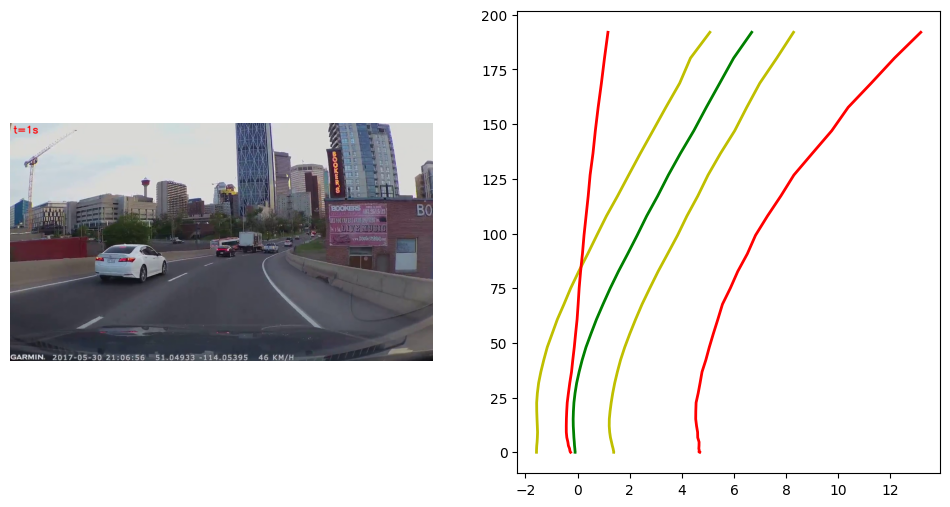

In [9]:
model_output = OutputWrapper(result)
model_output_050 = OutputWrapper(result_050)
model_output_100 = OutputWrapper(result_100)


visualizer.visualize(frame, model_output)

# Comparison
Red: original <br />
Green .5s distance<br />
Blue: 1s distance

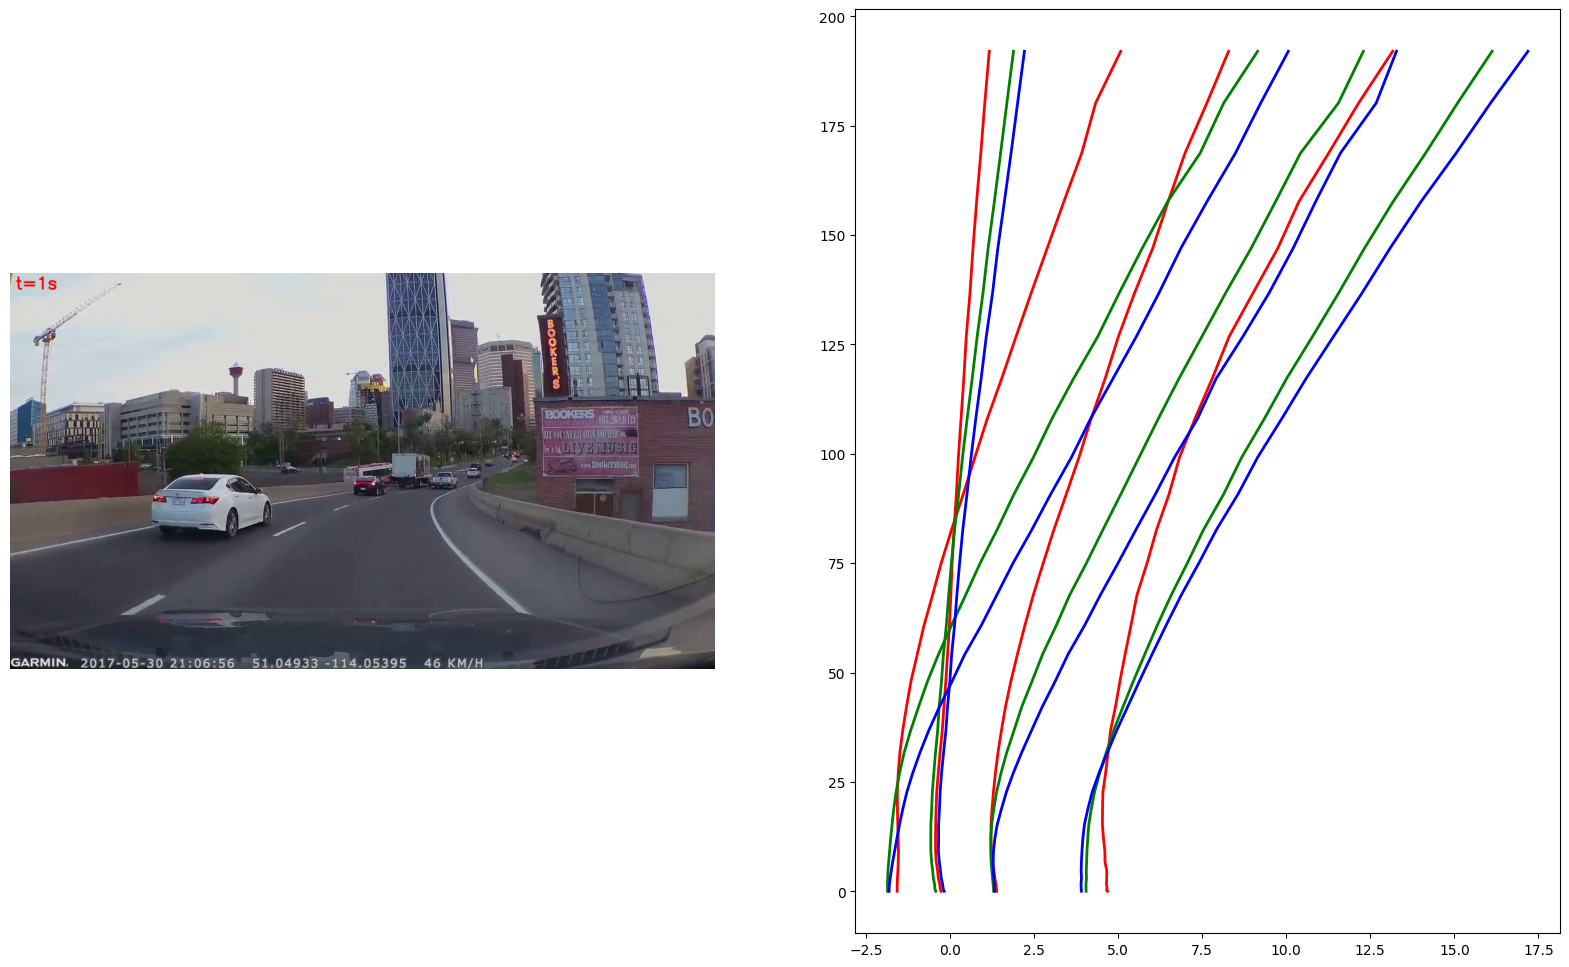

In [10]:

visualizer.compare_visualize(frame, (model_output, model_output_050, model_output_100))